# Readme
- 원본 이미지에서, crop(hub-localizer) -> classification 한번에 작업(localizer 1.14 이용했었다.)

# 넥라인 데이터

In [ ]:
!pip uninstall tensorflow
#!pip install tensorflow-gpu==1.14
!pip install tensorflow-gpu==1.14

In [ ]:
from tqdm import tqdm
import numpy as np

import os
import glob
import zipfile

#from PIL import Image # PIL은 조금 무거운것 같다
import cv2 # (주의)imshow 할때는 google에서 제공하는 lib 써야한다(아래 Lib)
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

import pandas as pd



---



---



# 1. 데이터

In [ ]:
### 이미지 - 구글 드라이브에 있는것 활용(압축해제 후 활용) ###

import zipfile

path_to_zip_file = 'ver1_round+square+v.zip' # 구글 드라이브에 저장된 zip 파일 경로
save_path = 'img'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(save_path)

In [ ]:
glob.glob('img/ver1_round+square+v/*')

['img/ver1_round+square+v/round',
 'img/ver1_round+square+v/square',
 'img/ver1_round+square+v/v']

In [ ]:
# img 폴더에 class 명으로 jpg 저장

import shutil

for class_path in glob.glob('img/ver1_round+square+v/*'):
  #print(class_path.split('/')[-1])
  class_name = class_path.split('/')[-1]
  class_len = len(glob.glob(class_path+'/*'))
  
  if class_name == 'round':
    for i, file_path in enumerate(glob.glob(class_path+'/*')):
      shutil.copy( file_path , 'img/{}_{}.jpg'.format(class_name, i))
  
  if class_name == 'square':
    for j, file_path in enumerate(glob.glob(class_path+'/*')):
      shutil.copy( file_path , 'img/{}_{}.jpg'.format(class_name, j))
    
  if class_name == 'v':
    for k, file_path in enumerate(glob.glob(class_path+'/*')):
      shutil.copy( file_path , 'img/{}_{}.jpg'.format(class_name, k))
  
  #for file_path in class_path:
  #  shutil

In [ ]:
len(glob.glob('img/*.jpg'))

750

In [ ]:
### 이런식으로, 각각의 class마다 다른 경로에 있을때에도 flow_from_directory로 간단하게 활용할 수 있다.
# create generator
#image_generator = ImageDataGenerator(rescale=1/255, 
#                                     rotation_range=40,
#                                     horizontal_flip=True,
#                                     vertical_flip=True,
#                                     validation_split=0.3)

 

#train_data_generator = image_generator.flow_from_directory(batch_size=32,
#                                                 directory='neckline',
#                                                 shuffle=True,
#                                                 target_size=(224, 224), 
#                                                 subset="training",
#                                                 class_mode='categorical')

 

#val_data_generator = image_generator.flow_from_directory(batch_size=32,
#                                                 directory='neckline',
#                                                 shuffle=True,
#                                                 target_size=(224, 224), 
#                                                 subset="validation",
#                                                 class_mode='categorical')



---



---



## - 파일명으로 데이터 기초 파악

In [ ]:
# 몇개의 이미지가 있는가?

# train
neckline_list = [l.split('/')[1] for l in glob.glob('img/*.jpg')]
print(len( neckline_list ) )



750


- 이미지 데이터 기초통계

In [ ]:
# Train 데이터
label = [l.split('_')[0] for l in neckline_list]
neckline_df = pd.DataFrame({'prod' : neckline_list, 'label' : label})

neckline_df.groupby('label').count()

,prod
label,
round,221
square,294
v,235




---



- label encoding : 한글을 matplotlib 에서 보여주는건 시간이 좀 걸려

In [ ]:
neckline_df['label']

0      square
1      square
2           v
3           v
4           v
        ...  
745    square
746         v
747    square
748         v
749     round
Name: label, Length: 750, dtype: object

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le_result = le.fit_transform( neckline_df['label'] )

In [ ]:
neckline_df['le_label'] = le_result

In [ ]:
neckline_df.head(3)

,prod,label,le_label
0,square_245.jpg,square,1
1,square_213.jpg,square,1
2,v_154.jpg,v,2


In [ ]:
neckline_df[['label' , 'le_label']].groupby('label')['le_label'].unique()

label
round     [0]
square    [1]
v         [2]
Name: le_label, dtype: object



---



---



# 1.1 img 데이터 load

In [ ]:


# class에 해당하는 img_path 불러온다
def get_class_img_path(class_int, is_train = True):
  
    class_dict = {
      0: ['round'], 
      1: ['square'],
      2: ['v']
    }

    class_img_path = []

    if is_train:
        file_path = 'img/*.jpg'
      
        # read file_path per class
        for path in glob.glob(file_path):
            if path.split('/')[1].split('_')[0] in class_dict[class_int]:
                class_img_path.append(path)

    else:
        file_path = 'test_image/*.jpg'
      
        # read file_path per class - test일 경우에는 [1]인자에 label 들어있다
        for path in glob.glob(file_path):
            if path.split('/')[1].split('_')[1] in class_dict[class_int]:
                class_img_path.append(path)

    
    
    return class_img_path



# 이미지를 불러온다 - 위메프 이미지 460*460 -> 192*192로 변환(object localizer에서 192*192받는다)
def read_img_class(img_path):
    

    img = cv2.imread(img_path) # array 형태
    # 정사각 (192, 192) - tf.hub localizer input size
    resize_img = cv2.resize(img, dsize=(192,192)  ,interpolation=cv2.INTER_AREA) # 축소일때는 interpolation값 : INTER_AREA
        
    return resize_img

In [ ]:
# load <train> image - with tqdm

from tqdm import tnrange, tqdm_notebook

image_per_class = {}
path_per_class = {}

n_class = 3

for i in tqdm_notebook(range(n_class)):
    # init
    image_per_class[i] = []
    path_per_class[i] = []
    
    # append class image
    for j, path in tqdm_notebook(enumerate(get_class_img_path(class_int = i))):
      
        ### *** img read 에러나는 경우 제외 ###
        try:
            # class 이미지 추가
            image_per_class[i].append( read_img_class(path) )
            # class 이미지 경로 추가
            path_per_class[i].append( path )
        except:
            pass
    # convert to numpy array & scaling
    image_per_class[i] = np.array( image_per_class[i] )/255.0
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()




---



---



# 2. (테스트성) 모델 import(localizer) & 테스트성으로 localized 이미지 확인
- train/test 데이터셋 모두 확인 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image
import numpy as np

HUB_PATH = "https://tfhub.dev/google/object_detection/mobile_object_localizer_v1/1"

#------------------------------
## STEP 1 : Object localiaztion

#------------------------------
# define graph

module = hub.Module(HUB_PATH)  # 1.14 에서 사용 - hub.module()
#module = hub.load(HUB_PATH) # 2.0 에서 사용 

height, width = hub.get_expected_image_size(module)
#height, width = (192,192) # tf 2.0에서

input_images = tf.placeholder(tf.uint8, shape=[None, None, None, 3], name='input_images')
input_images_float = tf.image.convert_image_dtype(input_images, dtype=tf.float32)

input_images_float = tf.image.resize_bilinear(
        input_images_float,
        [height, width],
        align_corners=False,
        name=None
    )

preds = module(input_images_float, signature="default", as_dict=True)

# make Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())


status = {
    'sess' : sess,
    'size' : (width, height),
    'input_images_tensor': input_images_float,
    'pred_tensor': preds
}

In [ ]:
# 배치성으로 작업하려면 필요
class BatchImageGenerator():
    def __init__(self, items, batch_size):
        self.size = len(items)
        self.batch_size = batch_size

        self.data = items
 
    def __iter__(self):
        self.index = 0
        return self
 
    def __next__(self):

        if self.index >= int(self.size / self.batch_size):
            raise StopIteration
 
        batch_data = self.data[self.index*self.batch_size:(self.index+1)*self.batch_size]
        self.index += 1

        return batch_data


In [ ]:
# get_origin_bbox

def get_origin_bbox(img, bbox):
    hegiht, width = img.shape[0], img.shape[1]

    y_min, x_min, y_max, x_max = bbox

    y_min = int(y_min * hegiht)
    y_max = int(y_max * hegiht)
    x_min = int(x_min * width)
    x_max = int(x_max * width)

    coord = (y_min, x_min, y_max, x_max)

    return coord

In [ ]:
# 0602_새로 시도해볼 ver : crop한 이미지 그대로 centering


def get_crop_img(img, bbox, neckline = False):
    # img : numpy_array
    # bbox : list [1,1,1,1]
    img = img[:, :, [2, 1, 0]] # bgr -> rgb 변환!
    
    background = np.zeros_like(img)

    size = img.shape[0]

    y_min, x_min, y_max, x_max = bbox
    ### 45%의 상위 이미지만 네크라인 이미지로 활용 ###
    if neckline == True:
      alpha = (y_max-y_min)*0.45
      y_max = np.int(y_min + alpha)

    roi = img[y_min:y_max, x_min:x_max]

    roi_height = roi.shape[0]
    roi_width = roi.shape[1]

    #roi = Image.fromarray(np.uint8(roi))

    roi_size = max(roi_height, roi_width)


    if roi_height == roi_size:
        check = 'height'
        re_height = size
        re_width = int(size * roi_width / roi_height)

    else:
        check = 'width'
        re_height = int(size * roi_height / roi_width)
        re_width = size

    # 변경 #
    resize_roi = cv2.resize(roi, dsize=(re_width,re_height)  ,interpolation=cv2.INTER_AREA) # 여기 바꿨다 - roi = Image.fromarray(np.uint8(roi)) 바뀌면서 수정한거야
    np_roi = np.array(resize_roi , dtype=np.uint8) # 형도 지정해주었다
    ###
    
    re_roi_height = np_roi.shape[0]
    re_roi_width = np_roi.shape[1]

    roi_y_coord = int(re_roi_height / 2)
    roi_x_coord = int(re_roi_width / 2)

    center = int(size / 2)

    if check == 'height':
        start = center - roi_x_coord
        end = start + re_roi_width

        background[:, start:end] = np_roi

    else:
        start = center - roi_y_coord
        end = start + re_roi_height

        background[start:end, :] = np_roi

    background = background.astype(np.uint8) # 한번 더 형 지정
    return background

In [ ]:
len(image_per_class)

3

In [ ]:
for i in range(3):
  print( 'class_{} :'.format(i), image_per_class[i].shape)

class_0 : (221, 192, 192, 3)
class_1 : (294, 192, 192, 3)
class_2 : (235, 192, 192, 3)


### - class 마다 crop작업 해본다

In [ ]:
CLS_SCORE = 0.2

# call graph info
sess = status['sess']
input_images_tensor = status['input_images_tensor']
pred_tensor = status['pred_tensor']

# do localization process
#batch_data_generator = BatchImageGenerator(class_0_img, 16)


##### define dict #####
crop_img_list_class = {}
crop_img_scores = {}

for k in range(3):
  ##### initialize_dict #####
  crop_img_list_class[k] = {}
  crop_img_scores[k] = {}

  ##### image_per_class에서 이미지 불러 crop #####  
  for i,img_scaling in enumerate( image_per_class[k] ):
    ##### initialize_list #####
    crop_img_list_class[k][i] = []
    crop_img_scores[k][i] = []
    ######

    origin_img = img_scaling*255
    #arr_img = [ resize_img(item['img']) for item in batch_data]
    #arr_img = np.array(arr_img)

    # make crop_items
    preds = sess.run(pred_tensor, feed_dict={input_images_tensor: img_scaling.reshape(1,192,192,3) })

    detection_boxes = preds['detection_boxes']
    detection_scores = preds['detection_scores']

    # for loop : img -> crop_img_items
    criterion = detection_scores > CLS_SCORE
    bboxes = detection_boxes[criterion]
    scores = detection_scores[criterion]
    
    ## bbox가 하나도 없으면 건너뛰기
    if len(bboxes) == 0:
      continue
    

    
    ### bbox들의 면적 계산해서, 가장 큰 bbox만 남기는 전략
    #max_bbox_index = np.argmax( [(bbox[2]-bbox[0])*(bbox[3]-bbox[1]) for bbox in list(bboxes)] )
    #bbox = bboxes[max_bbox_index]
    
    for scores, bbox in zip(scores, bboxes):
      # crop 작업
      origin_bbox = get_origin_bbox(origin_img, bbox)
      crop_img = get_crop_img(origin_img, origin_bbox) # non-max suppersion 변경 해야 함. origin_bbox -> bbox
      crop_img_list_class[k][i].append(crop_img)
      crop_img_scores[k][i].append(scores)

    #print(len(crop_img_list_class0[i]))

In [ ]:
class_0_index_list = list( crop_img_list_class[0].keys() )

sss_gt_1 = 0

for i in class_0_index_list:
  if len( crop_img_list_class[0][i] ) > 1:
    print( i, ':', len( crop_img_list_class[0][i] ) )
    sss_gt_1 += 1

1 : 2
2 : 4
3 : 3
4 : 3
7 : 2
8 : 2
9 : 2
10 : 3
12 : 2
13 : 2
15 : 3
16 : 2
17 : 2
18 : 2
19 : 3
20 : 2
24 : 3
25 : 2
26 : 3
29 : 2
30 : 2
32 : 2
35 : 2
37 : 2
39 : 3
43 : 2
44 : 6
45 : 2
46 : 2
47 : 3
52 : 5
53 : 4
54 : 2
56 : 2
59 : 2
61 : 3
62 : 3
63 : 3
64 : 4
65 : 2
67 : 2
68 : 2
70 : 2
71 : 2
73 : 5
74 : 2
78 : 3
80 : 2
82 : 2
84 : 2
85 : 2
89 : 3
90 : 2
93 : 3
96 : 2
100 : 5
101 : 2
102 : 2
103 : 2
107 : 2
108 : 2
109 : 2
111 : 2
112 : 2
116 : 5
118 : 4
119 : 3
120 : 2
121 : 2
123 : 4
124 : 3
125 : 2
126 : 2
127 : 2
129 : 3
131 : 2
134 : 3
135 : 4
139 : 4
143 : 3
145 : 3
147 : 2
149 : 2
153 : 2
154 : 2
155 : 3
156 : 2
159 : 6
163 : 2
167 : 2
168 : 2
169 : 2
172 : 4
173 : 2
174 : 5
176 : 2
181 : 3
182 : 2
183 : 2
184 : 2
185 : 2
186 : 2
187 : 2
189 : 3
191 : 2
193 : 3
194 : 2
197 : 2
198 : 3
202 : 2
204 : 4
207 : 3
208 : 3
210 : 4
211 : 2
212 : 2
213 : 2
214 : 2
216 : 2
217 : 2
219 : 3


In [ ]:
sss_gt_1/len(class_0_index_list) # 1개보다 많은 crop_img 비율

0.5475113122171946

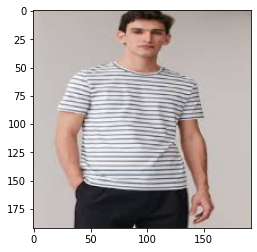

In [ ]:
plt.imshow( image_per_class[0][1][:,:,[2,1,0]] )

In [ ]:
# [class][image_index]

crop_img_scores[0][1]  # 2개의 crop 이미지 나올거야

[0.9774842, 0.474874]

In [ ]:
int(0.9774842*100)

97

0.9774842


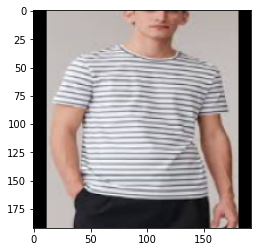

In [ ]:
index_k = 0

print( crop_img_scores[0][1][index_k] )
plt.imshow( crop_img_list_class[0][1][index_k] )

0.474874


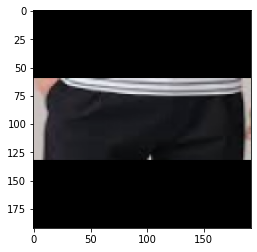

In [ ]:
index_k = 1

print( crop_img_scores[0][1][index_k] )
plt.imshow( crop_img_list_class[0][1][index_k] )

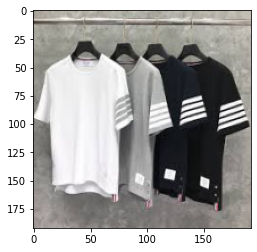

In [ ]:
plt.imshow( image_per_class[0][2][:,:,[2,1,0]] )

In [ ]:
# [class][image_index]

crop_img_scores[0][2]  # 2개의 crop 이미지 나올거야

[0.89049447, 0.7403716, 0.51939577, 0.38873133]

In [ ]:
int(0.9774842*100)

97

0.89049447


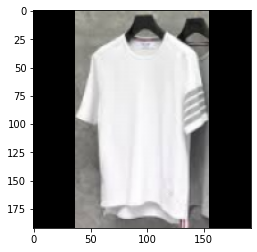

In [ ]:
index_k = 0

print( crop_img_scores[0][2][index_k] )
plt.imshow( crop_img_list_class[0][2][index_k] )

0.7403716


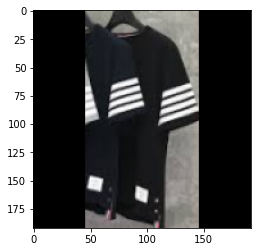

In [ ]:
index_k = 1

print( crop_img_scores[0][2][index_k] )
plt.imshow( crop_img_list_class[0][2][index_k] )

0.51939577


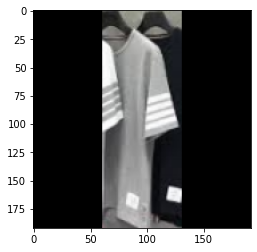

In [ ]:
index_k = 2

print( crop_img_scores[0][2][index_k] )
plt.imshow( crop_img_list_class[0][2][index_k] )

0.38873133


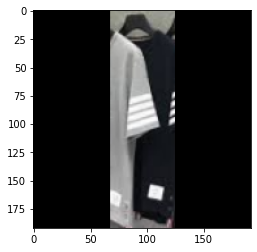

In [ ]:
index_k = 3

print( crop_img_scores[0][2][index_k] )
plt.imshow( crop_img_list_class[0][2][index_k] )

In [ ]:
##### 원본 이미지 저장 #####

folder_path_0 = 'crop_img/class_0/'
folder_path_1 = 'crop_img/class_1/'
folder_path_2 = 'crop_img/class_2/'

for j in range(3):
  if j == 0:
    folder_path = folder_path_0
  elif j == 1:
    folder_path = folder_path_1
  else:
    folder_path = folder_path_2

  for i in range(len(image_per_class[j])):
    cv2.imwrite( folder_path+'class{}_i_{}.png'.format( j,i ),   image_per_class[j][i]*255 )

In [ ]:
### crop_img 저장 : class_0

folder_path = 'crop_img/class_0/'

for k, v in crop_img_list_class[0].items(): # class[0] 에서 각각의 이미지 index:v 에 대해,
  for i,array in enumerate(v): # 각각의 이미지에서 crop된 images
    cv2.imwrite( folder_path+'class0_i_{}_k_{}_score_{}.png'.format(k, i, int(100*crop_img_scores[0][k][i]) ),   
                crop_img_list_class[0][k][i][:,:,[2,1,0]] ) # cv2를 이용해서 저장하므로, 다시 BGR로 돌려야한다

In [ ]:
### crop_img 저장 : class_1

folder_path = 'crop_img/class_1/'

for k, v in crop_img_list_class[1].items(): # class[0] 에서 각각의 이미지 index:v 에 대해,
  for i,array in enumerate(v): # 각각의 이미지에서 crop된 images
    cv2.imwrite( folder_path+'class1_i_{}_k_{}_score_{}.png'.format(k, i, int(100*crop_img_scores[1][k][i]) ),   
                crop_img_list_class[1][k][i][:,:,[2,1,0]] ) # cv2를 이용해서 저장하므로, 다시 BGR로 돌려야한다

In [ ]:
### crop_img 저장 : class_2

folder_path = 'crop_img/class_2/'

for k, v in crop_img_list_class[2].items(): # class[0] 에서 각각의 이미지 index:v 에 대해,
  for i,array in enumerate(v): # 각각의 이미지에서 crop된 images
    cv2.imwrite( folder_path+'class2_i_{}_k_{}_score_{}.png'.format(k, i, int(100*crop_img_scores[2][k][i]) ),   
                crop_img_list_class[2][k][i][:,:,[2,1,0]] ) # cv2를 이용해서 저장하므로, 다시 BGR로 돌려야한다

# # 가장 큰 하나의 crop_img에 대해서 neckline(상위 45%정도?) 잡아보기
- 면적이 가장 큰 이미지 하나에 대해서만

In [ ]:
CLS_SCORE = 0.4

# call graph info
sess = status['sess']
input_images_tensor = status['input_images_tensor']
pred_tensor = status['pred_tensor']

# do localization process
#batch_data_generator = BatchImageGenerator(class_0_img, 16)


##### define dict #####
crop_img_list_class_neck = {}
crop_img_scores_neck = {}

for k in range(3):
  ##### initialize_dict #####
  crop_img_list_class_neck[k] = {}
  crop_img_scores_neck[k] = {}
 
  ##### image_per_class에서 이미지 불러 crop #####  
  for i,img_scaling in enumerate( image_per_class[k] ):
    ##### initialize_list #####
    crop_img_list_class_neck[k][i] = []
    crop_img_scores_neck[k][i] = []
    ######

    origin_img = img_scaling*255
    #arr_img = [ resize_img(item['img']) for item in batch_data]
    #arr_img = np.array(arr_img)

    # make crop_items
    preds = sess.run(pred_tensor, feed_dict={input_images_tensor: img_scaling.reshape(1,192,192,3) })

    detection_boxes = preds['detection_boxes']
    detection_scores = preds['detection_scores']

    # for loop : img -> crop_img_items
    criterion = detection_scores > CLS_SCORE
    bboxes = detection_boxes[criterion]
    scores = detection_scores[criterion]
    
    ## bbox가 하나도 없으면 건너뛰기
    if len(bboxes) == 0:
      continue
    

    
    ### bbox들의 면적 계산해서, 가장 큰 bbox만 남기는 전략
    max_bbox_index = np.argmax( [(bbox[2]-bbox[0])*(bbox[3]-bbox[1]) for bbox in list(bboxes)] )
    bbox = bboxes[max_bbox_index]
    
    #for scores, bbox in zip(scores, bboxes):
      # crop 작업
    origin_bbox = get_origin_bbox(origin_img, bbox)
    crop_img = get_crop_img(origin_img, origin_bbox, neckline=True) # non-max suppersion 변경 해야 함. origin_bbox -> bbox
    crop_img_list_class_neck[k][i].append(crop_img)
    crop_img_scores_neck[k][i].append(scores)

    #print(len(crop_img_list_class0[i]))

In [ ]:
len(crop_img_list_class_neck[0] )

221

In [ ]:
crop_img_list_class_neck[0][0][0].shape

(192, 192, 3)

In [ ]:
# CLS : 0.2
for i in range(len(crop_img_list_class_neck[0]) ):
  cv2_imshow( crop_img_list_class_neck[0][i][0][:,:,[2,1,0]] )

In [ ]:
# CLS : 0.4
for i in range(len(crop_img_list_class_neck[0]) ):
  cv2_imshow( crop_img_list_class_neck[0][i][0][:,:,[2,1,0]] )

In [ ]:
### crop_img 저장 : class_0

folder_path_0 = 'crop_neckline/class_0/'
folder_path_1 = 'crop_neckline/class_1/'
folder_path_2 = 'crop_neckline/class_2/'

for class_ind in range(3):
  if class_ind == 0:
    folder_path = folder_path_0
  elif class_ind == 1:
    folder_path = folder_path_1
  else:
    folder_path = folder_path_2

  for image_ind in range(len(crop_img_list_class_neck[class_ind]) ):
    if len(crop_img_list_class_neck[class_ind][image_ind] ) > 0: # 해당 image_ind에서 crop이미지 없을 수 있다.
      cv2.imwrite( folder_path+'class_{}_{}.jpg'.format( class_ind, image_ind ),   
                  crop_img_list_class_neck[class_ind][image_ind][0][:,:,[2,1,0]] ) # cv2를 이용해서 저장하므로, 다시 BGR로



---



---



---



# 3. 훈련 & 평가

## Input Data 준비
- 데이터 프레이 활용
> - img_path / bbox / status(label)

In [ ]:
# get_localizer_model_bbox : bbox 얻도록 메소드 만들자

def get_localizer_model_bbox(class_int, is_train = True):
  
    # image_per_class 는 dict형태
    if is_train:
        image_class = image_per_class
    else:
        image_class = test_image_per_class
    
    CLS_SCORE = 0.4

    # call graph info
    sess = status['sess']
    input_images_tensor = status['input_images_tensor']
    pred_tensor = status['pred_tensor']

    # do localization process
    #batch_data_generator = BatchImageGenerator(class_0_img, 16)

    # origin_bbox_dict 으로 bbox 저장한다
    origin_bbox_dict = {}

    for i,img_scaling in enumerate( image_class[class_int] ):

        origin_img = img_scaling*255

        ##### localizer #####
        preds = sess.run(pred_tensor, feed_dict={input_images_tensor: img_scaling.reshape(1,192,192,3) })
        #####################

        detection_boxes = preds['detection_boxes']
        detection_scores = preds['detection_scores']


        # for loop : img -> crop_img_items
        criterion = detection_scores > CLS_SCORE
        bboxes = detection_boxes[criterion]

        ## bbox가 하나도 없으면 건너뛰기
        if len(bboxes) == 0:
            continue
    

    
        # bbox들의 면적 계산해서, 가장 큰 bbox만 남기는 전략
        max_bbox_index = np.argmax( [(bbox[2]-bbox[0])*(bbox[3]-bbox[1]) for bbox in list(bboxes)] )
        bbox = bboxes[max_bbox_index]
        # origin-bbox 얻기
        origin_bbox = get_origin_bbox(origin_img, bbox)
        origin_bbox_dict[i] = origin_bbox
    
    return origin_bbox_dict

In [ ]:
### for train - get bbox / path / status ###

total_path = []
total_bbox = []
total_status = []

### class 17 에 대해서 - path/bbox 얻는 작업 ###
for i in tqdm_notebook(range(3)):
  
    class_int_ = i
  
    class_bbox = get_localizer_model_bbox( class_int = class_int_ ) # 명시된 class에 대한 bbox -(dict형태)
    class_path = path_per_class[i] # path_per_class(dict)에서 해당 class list만 뽑아온다
  
    for k, bbox in tqdm_notebook(class_bbox.items()):
        total_path.append( class_path[k] ) # bbox 얻은 객체만 path 추가
        total_bbox.append( bbox )
        total_status.append( i )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [ ]:
print(len(total_path))
print(len(total_bbox))
print(len(total_status))

748
748
748


In [ ]:
## dataframe 만들기

df = pd.DataFrame({'filename':total_path, 'bbox':total_bbox, 'status':total_status})

df.head()

,filename,bbox,status
0,img/round_116.jpg,"(7, 37, 180, 159)",0
1,img/round_158.jpg,"(1, 48, 177, 178)",0
2,img/round_22.jpg,"(35, 58, 174, 149)",0
3,img/round_17.jpg,"(1, 53, 189, 146)",0
4,img/round_54.jpg,"(5, 57, 185, 132)",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559 entries, 0 to 3558
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3559 non-null   object
 1   bbox      3559 non-null   object
 2   status    3559 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 83.5+ KB


## # 불러와서 이용하자

In [ ]:
### 저장해서 이용하자 - tuple이 str로 변환되는 문제 : https://www.reddit.com/r/learnpython/comments/44dpgd/convert_pandas_dataframe_column_from_str_to_tuple/
import ast

#df.to_csv('gnecklinebbox_status_0619.csv', index=False)
df = pd.read_csv('necklinebbox_status_0619.csv',   converters={"bbox": ast.literal_eval} ) # 

In [ ]:
len(df)

748

In [ ]:
df.groupby('status').size()

status
0    221
1    292
2    235
dtype: int64

In [ ]:
# split dataframe / train(0.8), test(0.2)
total_data_count = len(df)
train_index = np.random.choice(len(df), int(0.8*len(df)), replace=False )


df_train = df[ df.index.isin(train_index)].reset_index(drop=True)
df_valid = df[~df.index.isin(train_index)].reset_index(drop=True)

In [ ]:
print(len(df_train), len(df_valid) )

598 150


## # 훈련셋만 균형지게 만들기

In [ ]:
# equal-sized 데이터 만들기

def make_equal_size(df, class_name=None):
  if not class_name:
    class_name = 'status'
  top_class = df[class_name].value_counts().index[0]
  size = df[df[class_name] == top_class].shape[0]

  df_equal_size = pd.DataFrame()
  for class_key, grp in df.groupby(class_name):
    if class_key == top_class:
      df_equal_size = pd.concat([df_equal_size, grp], axis=0)
    else:
      equal_sampled = grp.sample(n = size, replace=True)
      df_equal_size = pd.concat([df_equal_size, equal_sampled], axis=0)
  
  df_equal_size = df_equal_size.reset_index(drop=True)
  return df_equal_size

In [ ]:
# 불균형 데이터 맞춰준다
df_train = make_equal_size(df = df_train)

In [ ]:
df_train.groupby('status').size()

status
0    234
1    234
2    234
dtype: int64

---

## # using generator

In [ ]:
from tensorflow.keras.utils import Sequence

#------------------------------------------------------
# CropDataset
class CropDataset(Sequence):
    #---------------------------------------------
    # constructor
    def __init__(self, df, batch_size=16, target_size=(192,192), mode='train', shuffle=True, aug=False):

        self.len_df = len(df)
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        if mode == 'train' and aug == True:
            self.aug = True
        else:
            self.aug = False

        self.file_list = df['filename'].tolist()
        self.bbox_list = df['bbox'].tolist()

        self.label_list = df['status'].tolist()

        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(self.len_df) / self.batch_size)

    def __data_generation(self, indexes):

        X = np.empty((self.batch_size, *self.target_size, 3))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, idx in enumerate(indexes):

            file_name = self.file_list[idx]
            # img_path 경로를 추가.
            img_path = file_name

            img = self._read_img(img_path)
            bbox = self.bbox_list[idx]
            label = self.label_list[idx]

            crop_img = self._get_crop_img(img, bbox)
            # crop_img = self._get_crop_img2(img, bbox)
            resized_crop_img = self._resize_img(crop_img)

            # normalization
            resized_crop_img = resized_crop_img / 255.

            # data augmentation
            if self.aug:
                resized_crop_img = self._get_augmentated_img(resized_crop_img)

            X[i, ] = resized_crop_img
            y[i, ] = label

        return X, y

    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def _get_crop_img(self, img, bbox):
        # img : numpy_array
        # bbox : list [1,1,1,1]
        background = np.zeros_like(img)

        size = img.shape[0]

        y_min, x_min, y_max, x_max = bbox
        # 30%의 상위 이미지만 네크라인 이미지로 활용
        alpha = (y_max-y_min)*0.5
        y_max = np.int(y_min + alpha)


        roi = img[y_min:y_max, x_min:x_max]

        roi_height = roi.shape[0]
        roi_width = roi.shape[1]

        #roi = Image.fromarray(np.uint8(roi))

        roi_size = max(roi_height, roi_width)


        if roi_height == roi_size:
            check = 'height'
            re_height = size
            re_width = int(size * roi_width / roi_height)
        else:
            check = 'width'
            re_height = int(size * roi_height / roi_width)
            re_width = size

        resize_roi = cv2.resize(roi, dsize=(re_width,re_height)  ,interpolation=cv2.INTER_AREA) # 여기 바꿨다 - roi = Image.fromarray(np.uint8(roi)) 바뀌면서 수정한거야
        np_roi = np.array(resize_roi , dtype=np.uint8) # 형도 지정해주었다

        re_roi_height = np_roi.shape[0]
        re_roi_width = np_roi.shape[1]

        roi_y_coord = int(re_roi_height/2)
        roi_x_coord = int(re_roi_width/2)

        center = int(size / 2)

        if check == 'height':
            background[:, (center-roi_x_coord):(center-roi_x_coord+re_roi_width)] = np_roi
        else:
            background[(center-roi_y_coord):(center-roi_y_coord+re_roi_height), :] = np_roi
        
        background = background.astype(np.uint8) # 한번 더 형 지정

        return background

    def _read_img(self, img_path):
        
        img = cv2.imread(img_path) # array 형태
        cv2_resize_img = cv2.resize(img, dsize=(192,192)  ,interpolation=cv2.INTER_AREA)
        
        return cv2_resize_img

    def _resize_img(self, img):
  
        # img resize
        resize_img = cv2.resize(img, dsize=(192,192)  ,interpolation=cv2.INTER_AREA)

        np_img = np.array(resize_img)

        return np_img




    def _get_augmentated_img(self, img,
                              rotation_range= 10,
                              width_shift_range= 0.05,
                              height_shift_range= 0.05,
                              shear_intensity = False,
                              zoom_range= (1, 1), #(0.9, 1.1),
                              horizontal_flip=True,
                              vertical_flip=True
                              ):


        if rotation_range:
            img = tf.keras.preprocessing.image.random_rotation(img, rg = rotation_range, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)

        if width_shift_range:
            img = tf.keras.preprocessing.image.random_shift(img, wrg = width_shift_range, hrg = 0, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)

        if height_shift_range:
            img = tf.keras.preprocessing.image.random_shift(img, wrg = 0, hrg = height_shift_range, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)


        if shear_intensity:
            img = tf.keras.preprocessing.image.random_shear(img, intensity=shear_intensity, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)

        if zoom_range:
            img = tf.keras.preprocessing.image.random_zoom(img, zoom_range=zoom_range, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)

        if vertical_flip:
          vertical_flip_bool = np.random.choice( [True, False] )
          if vertical_flip_bool == True:
            img = tf.image.flip_up_down( img )

        #
        if horizontal_flip:
          horizontal_flip_bool = np.random.choice([True, False])
          if horizontal_flip_bool == True:
            img = tf.image.flip_left_right(img)

        return img


In [ ]:
val_data_generator[0][0][0].shape

(192, 192, 3)

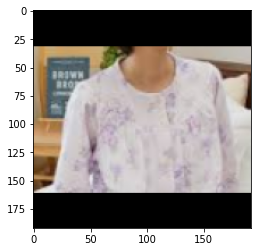

In [ ]:
plt.imshow( val_data_generator[0][0][0][:,:,[2,1,0]] )

In [ ]:
# parameter for training
BATCH_SIZE = 64
IMG_WIDTH = 192
AUG = True

# make train generator
train_data_generator = CropDataset(df = df_train,
                                    batch_size=BATCH_SIZE,
                                    target_size=(IMG_WIDTH, IMG_WIDTH),
                                    mode='train',
                                    shuffle=True,
                                    aug=AUG)

# make val generator
val_data_generator = CropDataset(df = df_valid,
                                  batch_size = len(df_valid),
                                  #batch_size = BATCH_SIZE,
                                  target_size=(IMG_WIDTH, IMG_WIDTH),
                                  mode='val',
                                  shuffle=False,
                                  aug=False)

In [ ]:
#test_data_generator = CropDataset(df = df_test_sample,
#                                  batch_size = len(df_test_sample),
#                                  target_size = (IMG_WIDTH, IMG_WIDTH),
#                                  mode = 'test',
#                                  shuffle=False,
#                                  aug=False                                  
#                                  )

## Training 실행

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop, SGD

input_shape = (IMG_WIDTH, IMG_WIDTH, 3)
METRICS = ['accuracy']
LOSS_FUNC = 'sparse_categorical_crossentropy'
NUM_CLASS = 3

# OPTIMIZER_FUNC = 'sgd'
# OPTIMIZER_FUNC = 'rmsprop'
OPTIMIZER_FUNC = 'adam'

# define model
model = Sequential([
    Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape = input_shape),
    MaxPooling2D(pool_size=(2,2)), # 112
    

    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # 56

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # 28

    Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # 14

    Flatten(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASS, activation='softmax')
])

# compile model
model.compile(
    loss=LOSS_FUNC,
    optimizer=OPTIMIZER_FUNC,
    metrics=METRICS
)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop, SGD

input_shape = (IMG_WIDTH, IMG_WIDTH, 3)
METRICS = ['accuracy']
LOSS_FUNC = 'sparse_categorical_crossentropy'
NUM_CLASS = 17

# OPTIMIZER_FUNC = 'sgd'
# OPTIMIZER_FUNC = 'rmsprop'
OPTIMIZER_FUNC = 'adam'

# define model
model2 = Sequential([
    Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape = input_shape),
    #BatchNormalization(),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2)), # 112
    

    Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # 56

    Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)), # 28

    Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
    #BatchNormalization(),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2)), # 14
    
    
    Flatten(),
    #Dropout(0.5),

    Dense(512, activation='relu'),
    #Dropout(0.5),
    Dense(NUM_CLASS, activation='softmax')
])

# compile model
model2.compile(
    loss=LOSS_FUNC,
    optimizer=OPTIMIZER_FUNC,
    metrics=METRICS
)

In [ ]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 192, 192, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 64)       

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 192, 192, 16)      448       
_________________________________________________________________
dropout_4 (Dropout)          (None, 192, 192, 16)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 16)       

In [ ]:
%%bash
mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [ ]:
%%bash
mkdir logs/fit

mkdir: cannot create directory ‘logs/fit’: File exists


In [ ]:
glob.glob('logs/*')

['logs/fit']

In [ ]:
import datetime
import tensorflow as tf

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
!nvidia-smi

Fri Jun 19 04:14:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    35W /  70W |   4823MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%load_ext tensorboard

In [ ]:
history = model2.fit_generator(
    train_data_generator,
    epochs = 100,
    validation_data=val_data_generator,
    verbose=1)

Epoch 1/100
10/10 [==============================] - 16s 2s/step - loss: 1.4749 - accuracy: 0.3469 - val_loss: 1.0980 - val_accuracy: 0.3933
Epoch 2/100
10/10 [==============================] - 16s 2s/step - loss: 1.0988 - accuracy: 0.4000 - val_loss: 1.1073 - val_accuracy: 0.5267
Epoch 3/100
10/10 [==============================] - 16s 2s/step - loss: 1.0723 - accuracy: 0.4422 - val_loss: 1.0672 - val_accuracy: 0.5000
Epoch 4/100
10/10 [==============================] - 16s 2s/step - loss: 1.0465 - accuracy: 0.4906 - val_loss: 1.0846 - val_accuracy: 0.3867
Epoch 5/100
10/10 [==============================] - 16s 2s/step - loss: 1.0497 - accuracy: 0.4594 - val_loss: 1.0468 - val_accuracy: 0.5400
Epoch 6/100
10/10 [==============================] - 16s 2s/step - loss: 1.0160 - accuracy: 0.4625 - val_loss: 1.0012 - val_accuracy: 0.5733
Epoch 7/100
10/10 [==============================] - 16s 2s/step - loss: 1.0346 - accuracy: 0.4906 - val_loss: 0.9891 - val_accuracy: 0.5533
Epoch 8/100
1

KeyboardInterrupt: ignored

In [ ]:
# 2020_0604 : batch_size 64 -> 32 로 줄이니깐 확실히 좋아졌다 
# 다시 64로?

history = model.fit_generator(
    train_data_generator,
    epochs = 100,
    validation_data=val_data_generator,
    verbose=1)

Epoch 1/100
43/43 [==============================] - 19s 435ms/step - loss: 4.3086 - accuracy: 0.3968 - val_loss: 2.4382 - val_accuracy: 0.2708
Epoch 2/100
43/43 [==============================] - 18s 429ms/step - loss: 1.5060 - accuracy: 0.4230 - val_loss: 3.5699 - val_accuracy: 0.3403
Epoch 3/100
43/43 [==============================] - 19s 437ms/step - loss: 1.2858 - accuracy: 0.4084 - val_loss: 3.0070 - val_accuracy: 0.3681
Epoch 4/100
43/43 [==============================] - 19s 435ms/step - loss: 1.1192 - accuracy: 0.3939 - val_loss: 2.5505 - val_accuracy: 0.4236
Epoch 5/100
43/43 [==============================] - 19s 433ms/step - loss: 1.1035 - accuracy: 0.4084 - val_loss: 1.5280 - val_accuracy: 0.4514
Epoch 6/100
43/43 [==============================] - 18s 429ms/step - loss: 1.0954 - accuracy: 0.4360 - val_loss: 1.3032 - val_accuracy: 0.4792
Epoch 7/100
43/43 [==============================] - 19s 432ms/step - loss: 1.0667 - accuracy: 0.4273 - val_loss: 1.4000 - val_accuracy:

KeyboardInterrupt: ignored